Generative adversarial network for X-ray image creation of the lung
===========

Packages

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as tt
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import glob
from skimage.transform import rescale, resize, downscale_local_mean
from tqdm import tqdm

Parameters

In [2]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print("Using device:",device)
print(torch.cuda.get_device_name(0))

image_size = 128
batch_size = 64
stats = (0.5), (0.5)

latent_size=100
lr=0.0002
mu1 = 0.5
mu2 = 0.999
num_epochs = 500

#torch.cuda.set_per_process_memory_fraction(0.9)

Using device: cuda
NVIDIA GeForce RTX 3060 Ti


Load Data
====

In [4]:
dataroot1="data\COVID_data"
dataroot2=r"data\Normal_data"

data_normal = dset.ImageFolder(dataroot2,transform=tt.Compose([ tt.Grayscale(), tt.Resize(image_size),tt.ToTensor(),tt.Normalize(*stats)]))
data_covid = dset.ImageFolder(dataroot1,transform=tt.Compose([ tt.Grayscale(), tt.Resize(image_size),tt.ToTensor(),tt.Normalize(*stats)]))

dataloader_normal = DataLoader(data_normal, batch_size, shuffle=True, num_workers=3, pin_memory=True)
dataloader_covid = DataLoader(data_covid, batch_size, shuffle=True, num_workers=3, pin_memory=True)

Show some training images

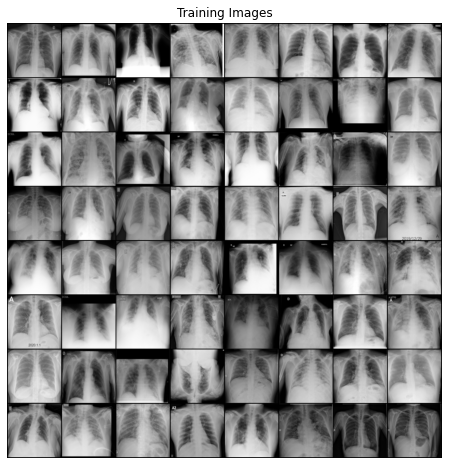

In [5]:
real_batch = next(iter(dataloader_covid))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Network
============

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),

            nn.Flatten(),
            nn.Sigmoid())

    def forward(self, input):
        return self.main(input)

Set up networks

In [16]:
netG_normal = Generator().to(device)
netG_covid = Generator().to(device)
netD_normal = Discriminator().to(device)
netD_covid = Discriminator().to(device)


summary(netG_normal, (latent_size,1,1))
summary(netD_normal, (1,image_size,image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

Training
========

Loss and optimizers

In [17]:
loss = nn.BCELoss()

optimizerD_normal = optim.Adam(netD_normal.parameters(), lr=lr, betas=(mu1, mu2))
optimizerG_normal = optim.Adam(netG_normal.parameters(), lr=lr, betas=(mu1, mu2))

optimizerD_covid = optim.Adam(netD_covid.parameters(), lr=lr, betas=(mu1, mu2))
optimizerG_covid = optim.Adam(netG_covid.parameters(), lr=lr, betas=(mu1, mu2))

Training function

In [18]:
def train(dataloader,netG,netD,optimizerG,optimizerD,loss,fixed_noise):

    real_label = 1
    fake_label = 0

    G_loss=0
    D_loss=0

    for i, data in enumerate(dataloader, 0):

        ####################
        # Update D network #
        ####################

        # First train with all-real batch
        netD.zero_grad()

        real_data = data[0].to(device) #create real batch
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_data).view(-1) #Forward pass trough D
        errD_real = loss(output, label) #Calculate loss
        errD_real.backward() #Backward process

        ## Train with fake batch
        noise = torch.randn(b_size, latent_size, 1, 1, device=device) # Generate random codes

        fake = netG(noise) # Forward pass trough G
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1) #Forward pass trough D
        errD_fake = loss(output, label) #Calculate loss
        errD_fake.backward() # Backward process
        
        errD = errD_real + errD_fake # Overall error
        optimizerD.step() # Update D

        ####################
        # Update G network #
        ####################

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are set to real
        output = netD(fake).view(-1) #Forward pass trough D with fake images from generator
        errG = loss(output, label) # Calculate loss
        errG.backward() #Backward process

        optimizerG.step() # Update G


        #store losses
        G_loss+=errG.item()
        D_loss+=errD.item()

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu() # generate image with fixed noise to see generator image development
    
    return G_loss/i,D_loss/i, fake


Training Normal GAN
-------------

Training

In [64]:
img_list = []
G_losses=np.zeros(num_epochs)
D_losses=np.zeros(num_epochs)
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

for t in tqdm(range(num_epochs)):
    G_losses[t], D_losses[t],fake = train(dataloader_normal, netG_normal,netD_normal,optimizerG_normal,optimizerD_normal, loss, fixed_noise) # training
    if t%10==0:
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True)) # every ten epochs store generator image with fixed noise

100%|██████████| 500/500 [1:56:40<00:00, 14.00s/it]


### Results

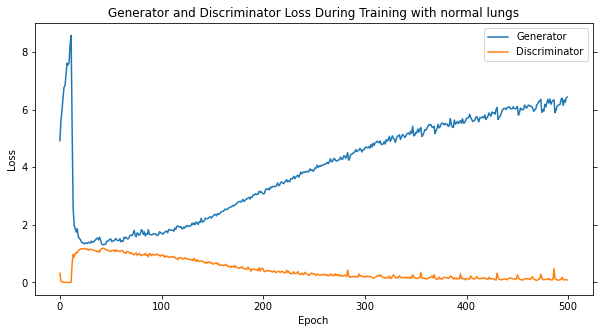

In [65]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training with normal lungs")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tick_params(right=True, top=False, labelright=False, labeltop=False)
plt.legend()
plt.show()

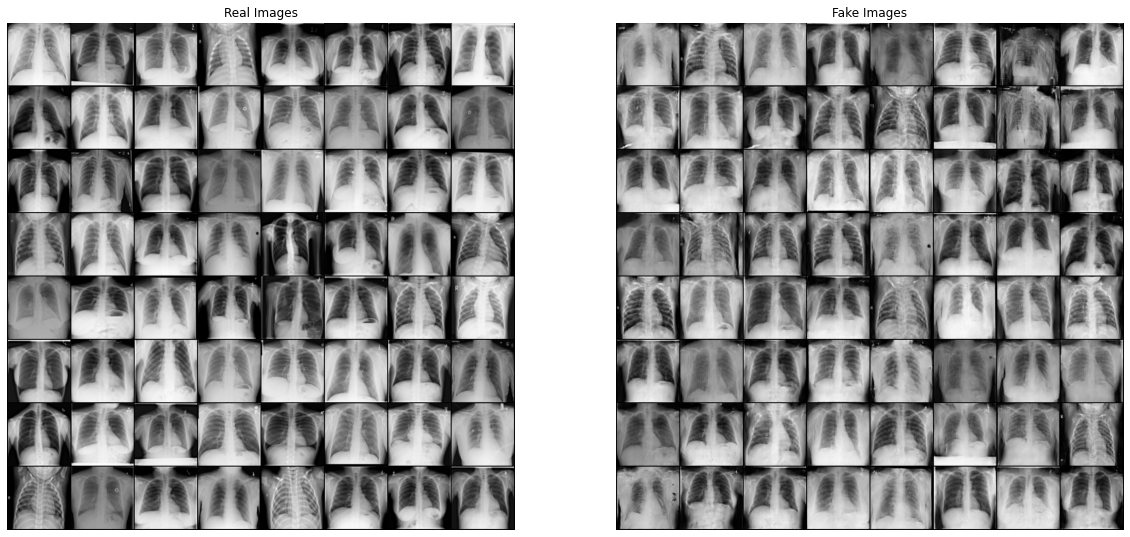

In [41]:
real_batch = next(iter(dataloader_normal))

# Plot the real images
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

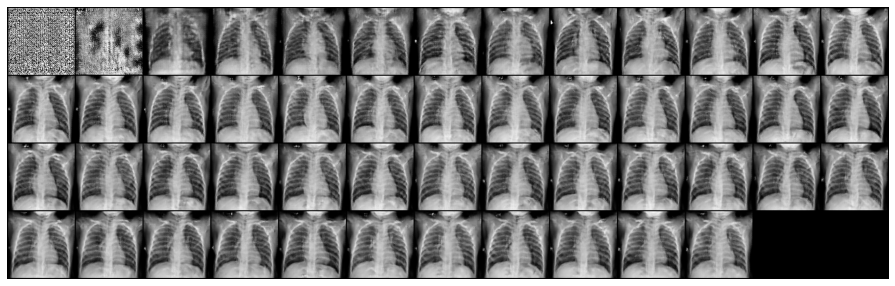

In [43]:
#Print image development
plt.figure(figsize=(20,5))
img_dev=torch.zeros((len(img_list),3,128,128))
for i in range(len(img_list)):
    img_dev[i]=img_list[i][:,2:130,132:260]
img=(vutils.make_grid(img_dev, padding=2, normalize=True,nrow=13))
plt.imshow(np.transpose(img,(1,2,0)))
plt.axis("off")
plt.show()

Training Covid GAN
-------------

In [ ]:
img_list = []
G_losses=np.zeros(num_epochs)
D_losses=np.zeros(num_epochs)
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

for t in tqdm(range(num_epochs)):
    G_losses[t], D_losses[t],D_x[t],D_G_z1[t],D_G_z2[t],fake = train(dataloader_covid, netG_covid,netD_covid,optimizerG_covid,optimizerD_covid, loss, fixed_noise) # training
    if t%10==0:
        #print(f"Epoch: {t},\n Loss Discriminator: {D_losses[t]:>6f}, \n Loss Generator: {G_losses[t]:>6f}")
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True)) # every ten epochs store generator image with fixed noise

### Results

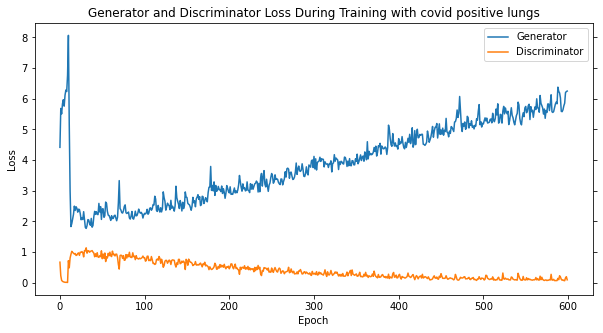

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training with covid positive lungs")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tick_params(right=True, top=False, labelright=False, labeltop=False)
plt.legend()
plt.show()

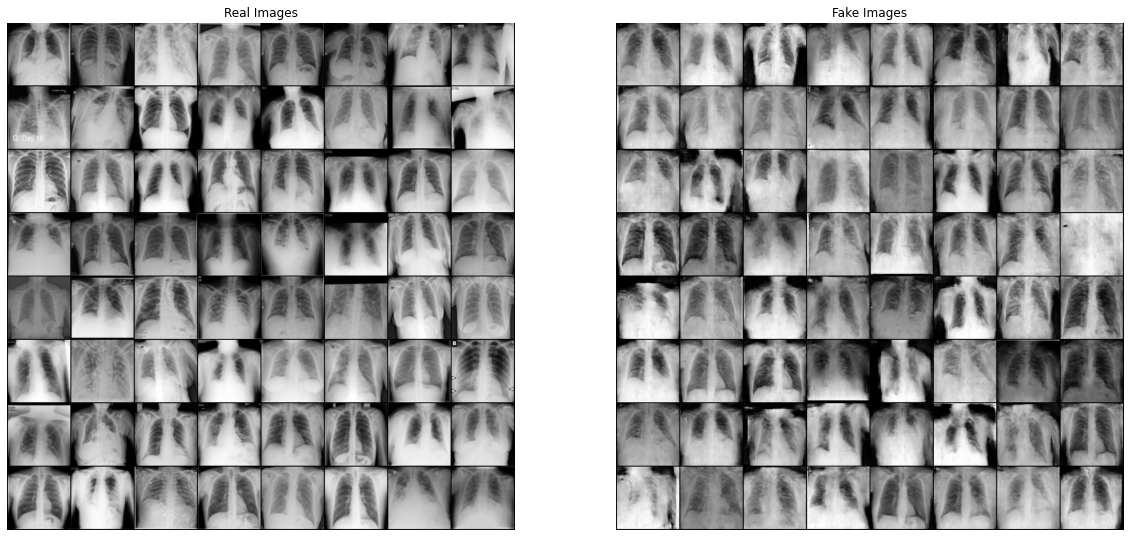

In [21]:
real_batch = next(iter(dataloader_covid))

# Plot the real images
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

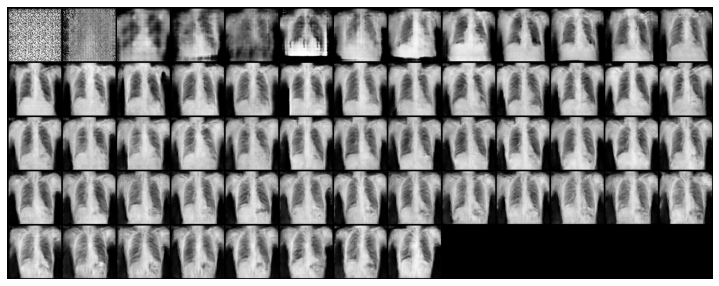

In [29]:
# Print image development
plt.figure(figsize=(20,5))
img_dev=torch.zeros((len(img_list),3,128,128))
for i in range(len(img_list)):
    img_dev[i]=img_list[i][:,0:128,260:388]
img=(vutils.make_grid(img_dev, padding=2, normalize=True,nrow=13))
plt.imshow(np.transpose(img,(1,2,0)))
plt.axis("off")
plt.show()

# Save trained Networks

In [23]:
torch.save(netG_normal,"models/GAN_netG_normal.pt")
torch.save(netD_normal,"models/GAN_netD_normal.pt")
torch.save(netG_covid,"models/GAN_netG_covid.pt")
torch.save(netD_covid,"models/GAN_netD_covid.pt")